In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from proj1_helpers import *
from implementations import *
from crossvalidation import *
from plots import * 
from data_preprocessing import *

## Load the training data into feature matrix, class labels, and event ids:

In [3]:
import zipfile 

In [4]:
zf_train = zipfile.ZipFile('data/train.csv.zip') 
zf_train.extractall()
zf_test = zipfile.ZipFile('data/test.csv.zip')
zf_test.extractall()

Before data preprocessing step, dimensions are:
x_train (for training) (250000, 30) x_test (568238, 30)


'save figure to before_processing'

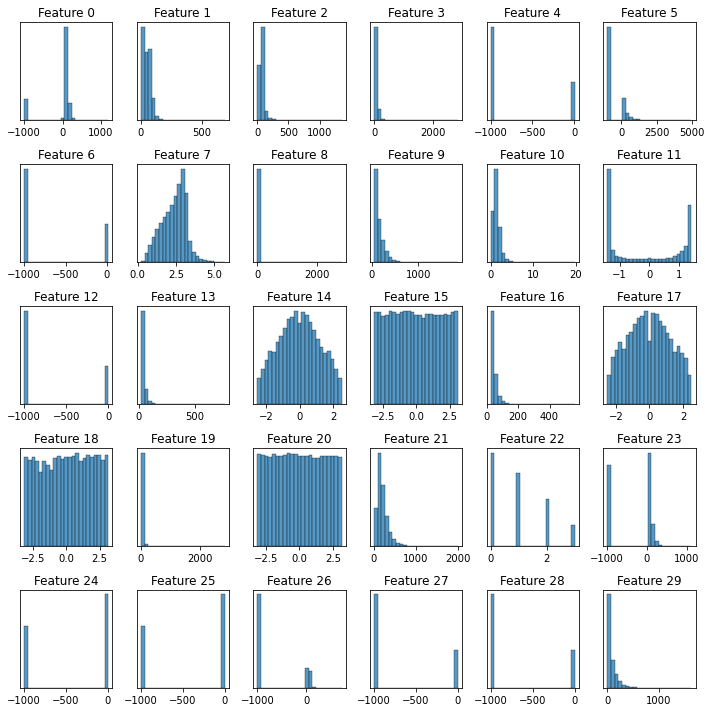

In [5]:
from proj1_helpers import *

DATA_TRAIN_PATH = 'train.csv' 
y_train, x_train, ids = load_csv_data(DATA_TRAIN_PATH)

DATA_TEST_PATH = 'test.csv'
_, x_test, ids_test = load_csv_data(DATA_TEST_PATH)

print("Before data preprocessing step, dimensions are:")
print('x_train (for training)', x_train.shape, 'x_test', x_test.shape)

multiple=int((x_train.shape[1])/5)
plot_data(x_train, "before_processing",5,multiple)

Data Preprocessing:

After data preprocessing step, dimensions are:
train (250000, 20) test (568238, 20)


'save figure to after_processing'

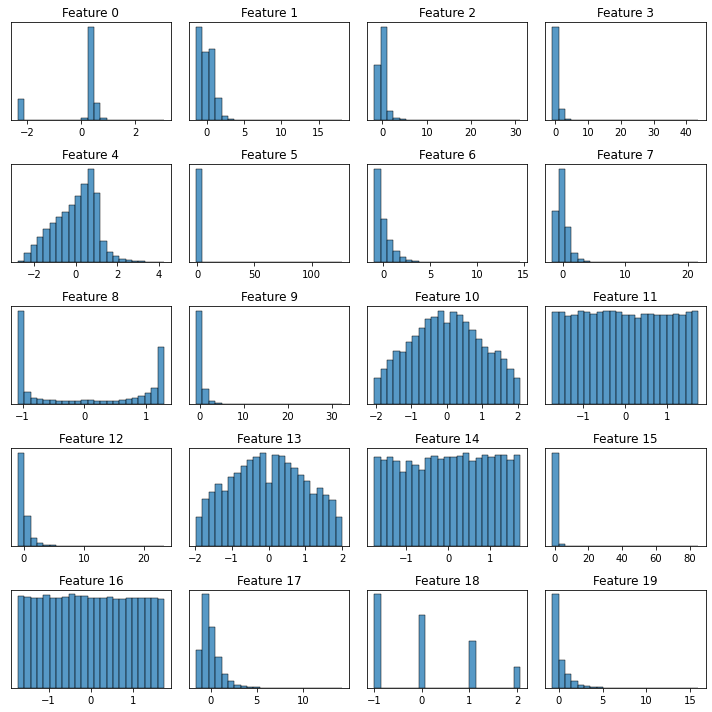

In [6]:
"""Pre-processing data:"""
x_train, x_test=data_preprocessing(x_train, x_test)
print("After data preprocessing step, dimensions are:")
print('train', x_train.shape, 'test', x_test.shape)

"""Visualization after data processing:"""
multiple=int((x_train.shape[1])/5)
plot_data(x_train,"after_processing",5,multiple)

## Do your thing crazy machine learning thing here :) ...

In [7]:
#least square model
w_ls, loss_ls=least_squares(y_train, x_train)
loss_ls

0.40178630841377566

In [8]:
#least square model with stochastic gradient descent
initial_w = np.zeros((x_train.shape[1], 1))
max_iters = 50
gamma= 0.01
w_sgd, loss_sgd=least_squares_SGD(y_train, x_train, initial_w, max_iters, gamma)

In [9]:
loss_sgd

0.5030095639556965

In [10]:
#cross validation for ridge regression

k_fold = 3
seed = 4
degree = 8

lambdas_ = np.linspace(2,4,40) #Lamdba for best submission : linspace(2,4,40)

losses_tr_ridge = []
losses_te_ridge = []
# split data in k fold
k_indices = build_k_indices(y_train, k_fold, seed)

for lambda_ in lambdas_:
    loss_tr_k = []
    loss_te_k = []
    for k in range(0,k_fold):
        w,loss_tr,loss_te = cross_validation_ridge(y_train, x_train, k_indices, k,degree, lambda_)
        loss_tr_k.append(loss_tr)
        loss_te_k.append(loss_te)
    losses_tr_ridge.append(np.mean(loss_tr_k))
    losses_te_ridge.append(np.mean(loss_te_k))

In [11]:
min(losses_te_ridge)

15554.828859687012

In [12]:
best_lambda_ridge = lambdas_[losses_te_ridge.index(min(losses_te_ridge))]
print(best_lambda_ridge)

2.2051282051282053


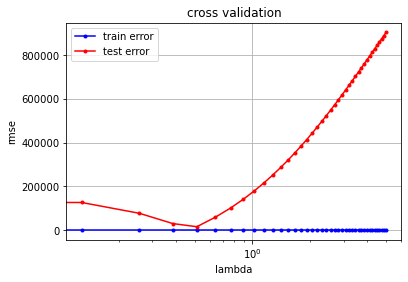

In [13]:
cross_validation_visualization(np.linspace(0, 5, 40), losses_tr_ridge, losses_te_ridge)

In [14]:
#cross validation for logistic regression

k_fold = 5
seed = 1
degree = 8

initial_w = np.zeros((x_train.shape[1], 1))
max_iters = 50
gamma= 0.01

lambdas_ = np.linspace(1,4,40)

losses_tr_log = []
losses_te_log = []
# split data in k fold
k_indices = build_k_indices(y_train, k_fold, seed)

for lambda_ in lambdas_:
    loss_tr_temp = []
    loss_te_temp = []
    for k in range(0,k_fold):
        w,loss_tr,loss_te = cross_validation_logistic(y_train, x_train, k_indices, k, lambda_, gamma,initial_w, 
                                                      max_iters, reg = True)
        loss_tr_temp.append(loss_tr)
        loss_te_temp.append(loss_te)
    losses_tr_log.append(np.mean(loss_tr_temp))
    losses_te_log.append(np.mean(loss_te_temp))
    

C:\Users\aguer\Documents\EPFL\M1\ML_course\ml-project-1-lpgsdesv\computations.py:43: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-t))


In [15]:
best_lambda_reg = lambdas_[losses_te_log.index(min(losses_te_log))]
print(best_lambda_reg)

2.8461538461538463


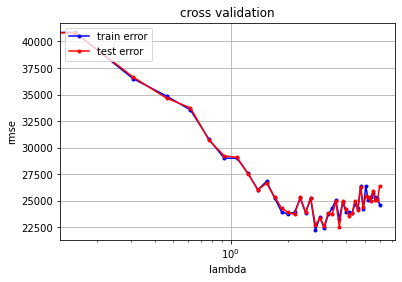

In [16]:
cross_validation_visualization(np.linspace(0, 6, 40), losses_tr_log, losses_te_log)

In [17]:
gamma= 0.001
w_reg, loss_reg= reg_logistic_regression(y_train, x_train, best_lambda_reg, initial_w, max_iters, gamma) 

C:\Users\aguer\Documents\EPFL\M1\ML_course\ml-project-1-lpgsdesv\computations.py:43: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-t))


In [18]:
w, loss= logistic_regression(y_train, x_train, initial_w, max_iters, gamma)

In [19]:
"""Now that we found the best lambda for the ridge regression, let's try to find the best degree, for ridge regression
applied on a polynomial extension"""

degree=np.arange(1,16+1)
loss=[]
w=[]
for deg in degree:
    x_poly=build_poly(x_train,deg)
    w_temp, loss_temp=ridge_regression(y_train, x_poly, best_lambda_ridge)
    loss.append(np.mean(loss_temp))
    w.append(w_temp)
best_deg=degree[loss.index(min(loss))]
print(best_deg)

13


In [20]:
#Build an augmented model with the degree used for CV and train ridge
x_poly_train = build_poly(x_train[:,:19],13)
x_train_aug = np.concatenate((x_poly,x_train[:,19:]),axis = 1)
x_poly_test = build_poly(x_test[:,:19],13)
x_test_aug = np.concatenate((x_poly_test,x_test[:,19:]),axis =1)
w_ridge, _ = ridge_regression(y_train, x_train_aug, best_lambda_ridge)

## Generate predictions and save ouput in csv format for submission:

In [23]:
OUTPUT_PATH = 'sample-submission.csv' # TODO: fill in desired name of output file for submission
#weights, loss=ridge_regression(y_train, x_train, best_lambda)
y_pred = predict_labels(w_ridge, x_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

ValueError: shapes (568238,20) and (322,) not aligned: 20 (dim 1) != 322 (dim 0)